In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
#to ignore warnings
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression

## Data Processing

In [88]:

data = pd.read_csv("Preprocessed_Data.csv")


## Feature Engineering

### Target Normalization: Comments per Hour

To make the target variable comparable across different time windows, we normalize the total comment volume by the prediction horizon `H_Local`, resulting in a consistent **comments per hour** metric.

Our data analysis revealed that the raw target volume is heavily influenced by the length of the time window used to record comments. Longer windows naturally lead to higher comment counts, which introduces bias and makes comparisons across samples unreliable.

By normalizing the target, we remove this dependency on window length. This allows the model to learn more generalizable engagement patterns, improving both training stability and prediction accuracy.


Now we split our dataset, to ensure feat engeneering is only calculated based on values of our train dataset.

In [89]:

train_df, test_df = train_test_split(
    data, test_size=0.2, random_state=42
)

train_df_raw = train_df.copy()
test_df_raw = test_df.copy()

train_df['Hourly_Target_Volume'] = train_df['Target_Comment_Volume'] / train_df['H_Local']

### Add Feature: Comment Section Turned Off

A new binary feature is added to indicate whether the comment section is likely turned off.

Our data analysis revealed that some posts—particularly from pages with high levels of engagement (e.g., many likes or page check-ins)—consistently had **no recorded comments**, despite being otherwise active. This pattern suggests that for certain posts, the **comment section may have been intentionally disabled**.

To capture this, we define a heuristic:  
If a post has a high number of shares (above the 25th percentile) but **zero tracked comments**, we flag it as having the comment section turned off.

The 25th percentile threshold for shares is calculated from the **training dataset** and is applied consistently to both the training and test datasets to ensure alignment and prevent data leakage.

In [90]:
share_thresh = np.percentile(train_df['Post_Share_Count'], 25)

mask_time_enough = train_df['Base_Time'] >= 10
mask_no_comments = train_df['CC1_Total_Comments'] == 0
mask_high_share  = train_df['Post_Share_Count']      > share_thresh

train_df['Comments_Section_Off'] = 0
train_df.loc[
    mask_time_enough & mask_no_comments & mask_high_share,
    'Comments_Section_Off'
] = 1

# test
mask_time_enough = test_df['Base_Time'] >= 10
mask_no_comments = test_df['CC1_Total_Comments'] == 0
mask_high_share  = test_df['Post_Share_Count']      > share_thresh

test_df['Comments_Section_Off'] = 0
test_df.loc[
    mask_time_enough & mask_no_comments & mask_high_share,
    'Comments_Section_Off'
] = 1

### Features: Hourly Rates for Past Comment Values

From our data analysis, we observed that a maximum of **72 hours** of comment data was recorded per post. The actual number of recorded hours varies and is indicated by the `Base_Time` column.

This variability introduces inconsistency in the CC1–CC4 features, which represent comment volumes over different historical windows:

- **CC1_Total_Comments**: All past comments up to `Base_Time`
- **CC2_Comments_Last_24h**: Comments from the last 24 hours
- **CC3_Comments_48_to_24h**: Comments from 24–48 hours ago
- **CC4_Comments_First_24h**: Comments from 48–72 hours ago

If `Base_Time` is less than the time window a feature is supposed to represent, the value becomes **incomplete and misleading**.  
For example:
- If `Base_Time` = 24, then both "first 24h" and "last 24h" cover the same period.
- If `Base_Time` = 5, then "last 24h" only includes 5 hours of data—not a full 24—making it incomparable to posts with a full 24-hour window.

To correct for this and ensure consistency, we transform these absolute comment counts into **comments per hour**. This normalization adapts each value to the actual time window it covers, allowing for fair comparison across samples.

We apply this logic to each CC feature by dividing by the effective number of hours available:
- For CC1: divide by `Base_Time`
- For CC2: divide by `min(24, Base_Time)`
- For CC3: divide by `min(24, Base_Time - 24)`
- For CC4: divide by `min(24, Base_Time - 48)`

This approach creates four new features: `Hourly_Rate_CC1` to `Hourly_Rate_CC4`, each representing the **average comment rate per hour** for their respective time segments.


In [91]:

train_df['Hourly_Rate_CC1'] = (
    train_df['CC1_Total_Comments']
    / np.maximum(train_df['Base_Time'], 1)
)
test_df['Hourly_Rate_CC1'] = (
    test_df['CC1_Total_Comments']
    / np.maximum(test_df['Base_Time'], 1)
)

# CC2 (last 24h)
train_df['Hourly_Rate_CC2'] = (
    train_df['CC2_Comments_Last_24h']
    / np.maximum(np.minimum(24, train_df['Base_Time']), 1)
)
test_df['Hourly_Rate_CC2'] = (
    test_df['CC2_Comments_Last_24h']
    / np.maximum(np.minimum(24, test_df['Base_Time']), 1)
)

# CC3 (24–48h)
train_df['Hourly_Rate_CC3'] = (
    train_df['CC3_Comments_48_to_24h']
    / np.maximum(
        np.minimum(24, train_df['Base_Time'] - 24),
        1
    )
)
test_df['Hourly_Rate_CC3'] = (
    test_df['CC3_Comments_48_to_24h']
    / np.maximum(
        np.minimum(24, test_df['Base_Time'] - 24),
        1
    )
)

# CC4 (first 24h)
train_df['Hourly_Rate_CC4'] = (
    train_df['CC4_Comments_First_24h']
    / np.maximum(
        np.minimum(24, train_df['Base_Time'] - 48),
        1
    )
)
test_df['Hourly_Rate_CC4'] = (
    test_df['CC4_Comments_First_24h']
    / np.maximum(
        np.minimum(24, test_df['Base_Time'] - 48),
        1
    )
)


### Feature: Category-Level Target Mean

We create an aggregate feature by calculating the average hourly target volume per page category from the training data. This captures the typical engagement level associated with each `Page_Category`.

Category_Target_Mean = average Hourly_Target_Volume per Page_Category

This feature is then merged into both the training and test datasets, using only the mapping derived from the training data to avoid data leakage.

**Why we added it:**  
This provides the model with contextual information about the general comment activity expected from each category, helping it make more informed predictions based on historical group-level behavior.


### Feature: Binned Target Means for Continuous Page Attributes

For each of the continuous page-level features:

- `Page_Popularity_Likes`
- `Page_Checkins`
- `Page_Talking_About`

we create new features that capture the **average target behavior across value ranges (bins)** of each variable.

**How it works:**

- In the training data, each feature is split into 30 quantile-based bins (`qcut`), ensuring balanced distribution.
- For each bin, we calculate the average `Hourly_Target_Volume`.
- This average is then mapped back as a new feature (e.g., `Page_Popularity_Likes_Bin_Target_Mean`), reflecting the typical engagement level for similar value ranges.
- These bin definitions and mean values are stored and then applied to the test data using `pd.cut`, ensuring consistency and avoiding data leakage.

**Why we added it:**

This transformation allows the model to leverage **nonlinear relationships** between continuous features and the target variable, while preserving interpretability. It smooths out noise and helps the model focus on broader patterns within value ranges rather than overfitting to raw numeric scales.


In [92]:

cont_feats = ['Page_Popularity_Likes', 'Page_Checkins', 'Page_Talking_About']
bin_edges = {}
bin_means = {}

for feat in cont_feats:
    bin_col   = feat + '_bin'
    mean_col  = feat + '_Bin_Target_Mean'

    # --- train: q‐cut, mean, map, save edges/measures, drop bin col
    train_df[bin_col] = pd.qcut(
        train_df[feat], q=30, duplicates='drop'
    )
    bmean = train_df.groupby(bin_col)['Hourly_Target_Volume'].mean()
    train_df[mean_col] = train_df[bin_col].map(bmean)
    bin_edges[feat] = train_df[bin_col].cat.categories
    bin_means[feat] = bmean
    train_df.drop(columns=[bin_col], inplace=True)

    # --- test: cut on train’s edges, map train’s means, drop bin col
    test_df[bin_col] = pd.cut(
        test_df[feat],
        bins=bin_edges[feat]
    )
    test_df[mean_col] = test_df[bin_col].map(bin_means[feat])
    test_df.drop(columns=[bin_col], inplace=True)

### Feature: Ratio of Past to Future Comment Rate (Aggregate-Based)

This feature represents the average ratio between a post’s recent past comment rate (last 24 hours) and its future comment rate. It is calculated by first computing individual future-to-past ratios in the training set, then averaging these within 100 quantile bins based on `Hourly_Rate_CC2` (comments per hour in the last 24h).

**Why we use bins:**  
Since we cannot use target values in the test dataset, we use the binned past activity (`Hourly_Rate_CC2`) to assign an average future-to-past ratio learned from the training data. This allows us to estimate future engagement in the test set using only features available at prediction time.

**Why it’s important:**  
It captures how typical it is for posts with a certain level of recent activity to continue receiving comments. This helps the model better estimate future comment volume based on historical engagement dynamics.


In [93]:
future_rate = train_df['Target_Comment_Volume'] / train_df['H_Local']
past_rate   = train_df['Hourly_Rate_CC2']

# 2) individual ratio = future_rate / past_rate, but zero if past_rate==0
train_df['Ratio_Indiv'] = np.where(
    past_rate == 0,
    0,
    future_rate / past_rate
)

# 3) exclude “off” rows from aggregation
train_df.loc[train_df['Comments_Section_Off'] == 1, 'Ratio_Indiv'] = np.nan

# 4) create 10 quantile bins on Hourly_Rate_CC2 (train only)
train_df['CC2_ratio_bin'] = pd.qcut(
    train_df['Hourly_Rate_CC2'],
    q=50,
    duplicates='drop'
)

# 5) compute mean ratio per CC2 bin (NaNs ignored)
ratio_group = (
    train_df
    .groupby('CC2_ratio_bin')['Ratio_Indiv']
    .mean()
    .reset_index()
    .rename(columns={'Ratio_Indiv': 'Ratio_Agg_Past24h_vs_Future'})
)

# 6) merge aggregate back onto train and zero‑out “off” rows
train_df = train_df.merge(ratio_group, on='CC2_ratio_bin', how='left')
train_df.loc[train_df['Comments_Section_Off'] == 1, 'Ratio_Agg_Past24h_vs_Future'] = 0

# 7) save the bin edges & clean up
ratio_bins = train_df['CC2_ratio_bin'].cat.categories
train_df.drop(columns=['Ratio_Indiv', 'CC2_ratio_bin'], inplace=True)


# --- TEST: apply train‑derived aggregates ---
# 1) bin test rows using train’s CC2 edges
test_df['CC2_ratio_bin'] = pd.cut(
    test_df['Hourly_Rate_CC2'],
    bins=ratio_bins
)

# 2) merge the train‑computed aggregates
test_df = test_df.merge(ratio_group, on='CC2_ratio_bin', how='left')

# 3) fill missing & zero‑out “off” rows
test_df['Ratio_Agg_Past24h_vs_Future'] = test_df['Ratio_Agg_Past24h_vs_Future'].fillna(0)
test_df.loc[test_df['Comments_Section_Off'] == 1, 'Ratio_Agg_Past24h_vs_Future'] = 0

# 4) clean up
test_df.drop(columns=['CC2_ratio_bin'], inplace=True)

In [94]:
# Save features
train_df = train_df.drop(['Hourly_Target_Volume'], axis=1)



In [95]:


# 2) Split into features (X) and target (y)
X_train      = train_df.drop(columns='Target_Comment_Volume')
y_train      = train_df['Target_Comment_Volume']

X_test       = test_df.drop(columns='Target_Comment_Volume')
y_test       = test_df['Target_Comment_Volume']

X_train_raw  = train_df_raw.drop(columns='Target_Comment_Volume')
y_train_raw  = train_df_raw['Target_Comment_Volume']

X_test_raw   = test_df_raw.drop(columns='Target_Comment_Volume')
y_test_raw   = test_df_raw['Target_Comment_Volume']


In [96]:
train_df.to_csv("train_df.csv", index=False)
test_df.to_csv("test_df.csv", index=False)

### Simple Baseline Model: Scaled Past Rate with Learned Ratio

This baseline model predicts the future number of comments using a simple, interpretable formula:

**Prediction = Past Hourly Rate × Future Time Window × Learned Ratio**

Specifically, it multiplies:
- `Hourly_Rate_CC2`: the recent comment rate (last 24 hours),
- `H_Local`: the number of future hours to predict,
- `Ratio_Agg_Past24h_vs_Future`: a learned adjustment factor that reflects how recent activity typically translates into future engagement.

**Why this works:**  
This model leverages recent comment trends and adjusts them based on historical behavior patterns learned from the training data. It's a lightweight, explainable benchmark that gives a solid starting point for evaluating more complex models.

In [97]:
def simple_predict(df):
    return df['Hourly_Rate_CC2'] * df['H_Local'] * df['Ratio_Agg_Past24h_vs_Future']

y_pred = simple_predict(X_test)

# 2. Evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# 3. Print results
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")

Mean Absolute Error (MAE): 4.50
Mean Squared Error (MSE): 499.42


                                       Target_Comment_Volume  \
Target_Comment_Volume                               1.000000   
Comments_Section_Off                               -0.038571   
Hourly_Rate_CC1                                     0.713718   
Hourly_Rate_CC2                                     0.716889   
Hourly_Rate_CC3                                     0.097582   
Hourly_Rate_CC4                                     0.402815   
Page_Popularity_Likes_Bin_Target_Mean               0.195523   
Page_Checkins_Bin_Target_Mean                       0.047909   
Page_Talking_About_Bin_Target_Mean                  0.249340   
Ratio_Agg_Past24h_vs_Future                         0.004124   

                                       Comments_Section_Off  Hourly_Rate_CC1  \
Target_Comment_Volume                             -0.038571         0.713718   
Comments_Section_Off                               1.000000        -0.049669   
Hourly_Rate_CC1                                   -0.04

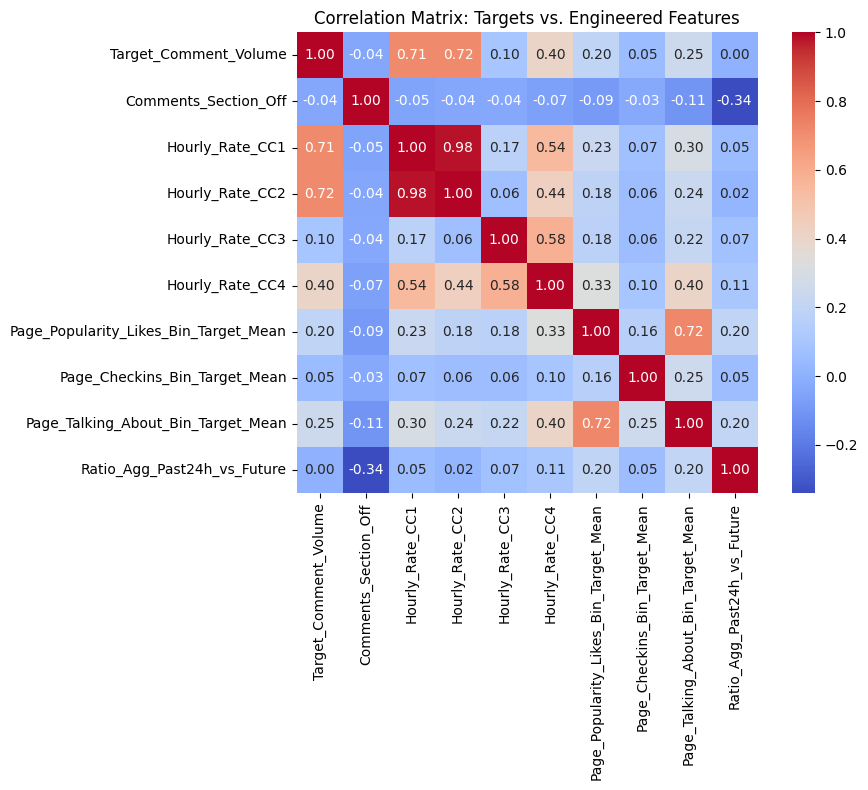

In [98]:

# 2) Select the newly added features + targets
corr_cols = [
    'Target_Comment_Volume',
    'Comments_Section_Off',
    'Hourly_Rate_CC1',
    'Hourly_Rate_CC2',
    'Hourly_Rate_CC3',
    'Hourly_Rate_CC4',
    'Page_Popularity_Likes_Bin_Target_Mean',
    'Page_Checkins_Bin_Target_Mean',
    'Page_Talking_About_Bin_Target_Mean',
    'Ratio_Agg_Past24h_vs_Future'
]

# 3) Compute correlation matrix
corr_matrix = train_df[corr_cols].corr()

# 4) Print and plot
print(corr_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Correlation Matrix: Targets vs. Engineered Features")
plt.tight_layout()
plt.show()

Now we want to conduct first tests, to see if our features have a positive impact on model. Therefore we train a simple model on the raw data, and the data extended with out features.

Save dataset with features to csv, so it can be used for model training

In [99]:
from sklearn.tree import DecisionTreeRegressor

dt_raw = DecisionTreeRegressor(random_state=42)
dt_raw.fit(X_train_raw, y_train_raw)

# 5) Predict & evaluate
y_pred_raw = dt_raw.predict(X_test_raw)
mae = mean_absolute_error(y_test_raw, y_pred_raw)
mse = mean_squared_error(y_test_raw, y_pred_raw)

print("Decision Tree on Raw Original Data")
print(f"  MAE: {mae:.2f}")
print(f"  MSE: {mse:.2f}")

lr_raw = LinearRegression()
lr_raw.fit(X_train_raw, y_train_raw)

# Predict and evaluate
y_pred_lr = lr_raw.predict(X_test_raw)
mae_lr = mean_absolute_error(y_test_raw, y_pred_lr)
mse_lr = mean_squared_error(y_test_raw, y_pred_lr)

print("Linear Regression on Raw Original Data")
print(f"  MAE: {mae_lr:.2f}")
print(f"  MSE: {mse_lr:.2f}")

Decision Tree on Raw Original Data
  MAE: 5.71
  MSE: 957.41
Linear Regression on Raw Original Data
  MAE: 8.23
  MSE: 675.78


The prediction results are significantly better with our newly constructed features: Especially the MSE dropped, meaning there are less "very off" predictions

In [100]:
dt_orig = DecisionTreeRegressor(random_state=42)
dt_orig.fit(X_train, y_train)
y_pred_orig = dt_orig.predict(X_test)

mae_orig = mean_absolute_error(y_test, y_pred_orig)
mse_orig = mean_squared_error(y_test, y_pred_orig)
r2_orig = r2_score(y_test, y_pred_orig)

print("Decision Tree on Data with new Features")
print(f"  MAE: {mae_orig:.2f}")
print(f"  MSE: {mse_orig:.2f}")
print(f"  R²:  {r2_orig:.2f}\n")

# Linear Regression on original features
lr_raw = LinearRegression()
lr_raw.fit(X_train, y_train)

y_pred_lr = lr_raw.predict(X_test)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print("Linear Regression on Data with new Features")
print(f"  MAE: {mae_lr:.2f}")
print(f"  MSE: {mse_lr:.2f}")
print(f"  R²:  {r2_lr:.2f}")

Decision Tree on Data with new Features
  MAE: 5.34
  MSE: 704.43
  R²:  0.34

Linear Regression on Data with new Features
  MAE: 5.93
  MSE: 419.59
  R²:  0.61



## Exemplary Feature Selection:


### Feature Selection with RFECV and Model Evaluation

This process uses **Recursive Feature Elimination with Cross-Validation (RFECV)** to identify the most relevant features for predicting comment volume.

- A **Linear Regression** model is used to rank features based on importance.
- Features are removed one at a time, and 5-fold cross-validation is used to evaluate performance (MSE).
- The optimal number of features is selected by minimizing validation error.

After selecting the best subset of features, two models — **Linear Regression** and **Decision Tree Regressor** — are trained and evaluated on the reduced feature set using MAE and MSE.

This helps identify a compact, high-performing feature set and compare model performance on it.


In [101]:
# from sklearn.feature_selection import RFECV
# from sklearn.linear_model import LinearRegression
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.metrics import mean_absolute_error, mean_squared_error
# import matplotlib.pyplot as plt

# # Base estimator for ranking
# est = LinearRegression()

# # RFECV: step=1 removes one feature at a time, cv=5 folds
# rfecv = RFECV(
#     estimator=est,
#     step=1,
#     cv=5,
#     scoring='neg_mean_squared_error',
#     min_features_to_select=1,
#     n_jobs=-1
# )
# rfecv.fit(X_train, y_train)

# opt_n = rfecv.n_features_
# print("Optimal feature count:", opt_n)
# selected = X_train.columns[rfecv.support_]
# print("Selected features:", list(selected))

# # Extract the CV‐fold MSE for each number of features
# # Note: mean_test_score is negative MSE (because scoring='neg_mean_squared_error')
# mse_scores = -rfecv.cv_results_['mean_test_score']

# # Plot MSE vs. #features
# plt.figure(figsize=(6,4))
# plt.plot(
#     np.arange(1, len(mse_scores) + 1),
#     mse_scores,
#     marker='o'
# )
# plt.xlabel("Number of features selected")
# plt.ylabel("CV MSE")
# plt.title("RFECV — CV MSE vs. #features")
# plt.tight_layout()
# plt.show()

# # And then re‐fit on the selected subset
# X_tr_rfecv = rfecv.transform(X_train)
# X_te_rfecv = rfecv.transform(X_test)

# for Model in (LinearRegression, DecisionTreeRegressor):
#     m = Model().fit(X_tr_rfecv, y_train)
#     pred = m.predict(X_te_rfecv)
#     mae = mean_absolute_error(y_test, pred)
#     mse = mean_squared_error(y_test, pred)
#     r2 = r2_score(y_test, pred)
#     print(f"{Model.__name__} on RFECV features — MAE: {mae:.2f}, MSE: {mse:.2f}, R²: {r2:.2f}")

### Feature Selection with Sequential Floating Forward Selection (SFS)

This approach uses **Sequential Floating Forward Selection (SFS)** to automatically identify the best subset of features for predicting comment volume.

- A **Linear Regression** model is used as the base estimator.
- Features are added iteratively in a forward fashion, with the option to remove previously added features if they become less useful (floating).
- The number of features is determined automatically by optimizing cross-validated performance (MSE).

After selecting the optimal features, both **Linear Regression** and **Decision Tree Regressor** models are trained and evaluated on the reduced feature set using MAE and MSE.

This method offers a more flexible and potentially more accurate alternative to standard forward selection.

Due to resource constaints, the categorical featuers are dropped for this

In [102]:
# # pip install mlxtend
# from mlxtend.feature_selection import SequentialFeatureSelector as SFS
# from sklearn.linear_model import LinearRegression
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.metrics import mean_absolute_error, mean_squared_error

# # Floating SFS: k_features='best' lets it decide how many features to keep
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# # Floating SFS
# sfs = SFS(
#     estimator=LinearRegression(),
#     k_features='best',
#     forward=True,
#     floating=True,
#     scoring='neg_mean_squared_error',
#     cv=5,
#     n_jobs=-1
# )
# sfs = sfs.fit(X_train_no_cat.values, y_train.values)

# feat_idx = list(sfs.k_feature_idx_)
# feat_names = X_train_no_cat.columns[feat_idx]
# print("Best #features:", len(feat_idx))
# print("Selected features:", feat_names)

# # Transform and evaluate
# X_tr = sfs.transform(X_train_no_cat.values)
# X_te = sfs.transform(X_test_no_cat.values)

# for Model in (LinearRegression, DecisionTreeRegressor):
#     m = Model().fit(X_tr, y_train)
#     pred = m.predict(X_te)
#     mae = mean_absolute_error(y_test, pred)
#     mse = mean_squared_error(y_test, pred)
#     r2 = r2_score(y_test, pred)
#     print(f"{Model.__name__} — MAE: {mae:.2f}, MSE: {mse:.2f}, R²: {r2:.2f}")


--> Some of our added features were selected as relevant !!!

The output shows, that our newly added features where selected by the Linear Model, and therefore are relevant for prediction.